# Gradient-boosting decision tree (GBDT)

In this notebook, we will present the gradient boosting decision tree
algorithm and contrast it with AdaBoost.

Gradient-boosting differs from AdaBoost due to the following reason: instead
of assigning weights to specific samples, GBDT will fit a decision tree on
the residuals error (hence the name "gradient") of the previous tree.
Therefore, each new tree in the ensemble predicts the error made by the
previous learner instead of predicting the target directly.

In this section, we will provide some intuition about the way learners are
combined to give the final prediction. In this regard, let's go back to our
regression problem which is more intuitive for demonstrating the underlying
machinery.

In [2]:
import pandas as pd
import numpy as np

# Create a random number generator that will be used to set the randomness
rng = np.random.RandomState(0)


def generate_data(n_samples=50):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_max, x_min = 1.4, -1.4
    len_x = x_max - x_min
    x = rng.rand(n_samples) * len_x - len_x / 2
    noise = rng.randn(n_samples) * 0.3
    y = x ** 3 - 0.5 * x ** 2 + noise

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(np.linspace(x_max, x_min, num=300),
                             columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train


data_train, data_test, target_train = generate_data()

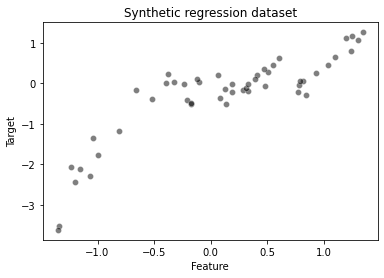

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")